# Patch based Data Loading for Training

In [1]:
import os
import random

import numpy as np
import SimpleITK as sitk
import torch
from torch.utils.data import Dataset

from viz_utils import NdimageVisualizer

In [2]:
visualizer = NdimageVisualizer()

In [3]:
OUT_OF_BODY_HU = -1024
OUT_OF_BODY_SUV = 0

## General utils

In [4]:
def load(file_path):
    reader = sitk.ImageFileReader()
    reader.SetFileName(str(file_path))
    sitk_image = reader.Execute()
    return sitk_image

def get_npy(sitk_image):
    return sitk.GetArrayFromImage(sitk_image)

def min_max_normalize(image, min_value, max_value):
    image = image.float()
    image = (image - min_value) / (max_value - min_value)
    return 2 * image - 1

def apply_body_mask(image_dict):
    body_mask = image_dict['body-mask']

    for k in image_dict.keys():
        if 'PET' in k:
            image_dict[k] = np.where(body_mask, image_dict[k], OUT_OF_BODY_SUV)
        elif 'CT' in k:
            image_dict[k] = np.where(body_mask, image_dict[k], OUT_OF_BODY_HU)

    return image_dict


def sitk2np(image_dict):
    # WHD to DHW
    for k in image_dict.keys():
        image_dict[k] = get_npy(image_dict[k])
    return image_dict

def np2tensor(image_dict):
    for k in image_dict.keys():
        image_dict[k] = torch.tensor(image_dict[k])
    return image_dict

## Patch sampling utils

In [5]:
PAIRED_SAMPLING_SCHEMES = ('uniform-random-within-body', 'fdg-pet-weighted')
UNPAIRED_SAMPLING_SCHEMES = ('uniform-random-within-body-sf', 'fdg-pet-weighted-sf')


class PairedPatchSampler3D():
    """3D patch sampler for paired training.

    Available patch sampling schemes:
        1. 'uniform-random-within-body'
        2. 'fdg-pet-weighted'
    """
    def __init__(self, patch_size, sampling):

        if sampling not in PAIRED_SAMPLING_SCHEMES:
            raise ValueError(f"`{sampling}` not a valid paired patch sampling scheme. \
                               Available schemes: {PAIRED_SAMPLING_SCHEMES}")

        self.patch_size = np.array(patch_size)
        self.sampling = sampling


    def get_patch_pair(self, image_dict_A, image_dict_B):
        
        # Sample a single focal point to be used for both domain A and B images
        # Domain A and domain B images are expected to be voxel-to-voxel paired
        focal_point = self._sample_common_focal_point(image_dict_A)

        # Extract patches from all volumes given this focal point and the patch size
        start_idx = focal_point - np.floor(self.patch_size/2)
        end_idx = start_idx + self.patch_size
        z1, y1, x1 = start_idx.astype(np.uint16)
        z2, y2, x2 = end_idx.astype(np.uint16)
    
        patch_dict_A, patch_dict_B = {}, {}
        for k in image_dict_A.keys():
            patch_dict_A[k] = image_dict_A[k][z1:z2, y1:y2, x1:x2]
        for k in image_dict_B.keys():
            patch_dict_B[k] = image_dict_B[k][z1:z2, y1:y2, x1:x2]
        
        return patch_dict_A, patch_dict_B


    def _sample_common_focal_point(self, image_dict_A):        
        body_mask = image_dict_A['body-mask']
        volume_size = body_mask.shape[-3:]  # DHW

        # Initialize sampling probability map as a volumetric mask of body region contained inside the 
        # volume's valid patch region (i.e. suffieciently away from the volume borders)
        sampling_prob_map = init_sampling_probability_map(volume_size, self.patch_size, body_mask)

        # Depending on the sampling technique, construct the probability map
        if self.sampling == 'uniform-random-within-body':
            # Uniform random over all valid focal points
            sampling_prob_map = sampling_prob_map / np.sum(sampling_prob_map)

        elif self.sampling == 'fdg-pet-weighted':
            # Random sampling, biased to high SUV regions in FDG-PET
            FDG_PET_volume = image_dict_A['FDG-PET']
            # Clip negative values to zero 
            FDG_PET_volume = np.clip(FDG_PET_volume, 0, None)
            # Update the probability map
            sampling_prob_map = sampling_prob_map * FDG_PET_volume
            sampling_prob_map = sampling_prob_map / np.sum(sampling_prob_map)

        # Sample focal points using this probability map
        focal_point = sample_from_probability_map(sampling_prob_map)

        return np.array(focal_point).astype(np.uint16)



class UnpairedPatchSampler3D():
    """3D patch sampler for unpaired training.

    Variations of Stochastic Focal patch sampling, where different schemes 
    differ in the way the focal point is sampled from domain A image(s).
    Essentially, the schemes implement different "prior" patch sampling 
    probability distributions.


    Available patch sampling schemes:
        1. 'uniform-random-sf'
        2. 'fdg-pet-weighted-sf'
    """
    def __init__(self, patch_size, sampling, focal_region_proportion):

        if sampling not in UNPAIRED_SAMPLING_SCHEMES:
            raise ValueError(f"`{sampling}` not a valid unpaired patch sampling scheme. \
                               Available schemes: {UNPAIRED_SAMPLING_SCHEMES}")

        self.patch_size = np.array(patch_size)
        self.sampling = sampling
        self.focal_region_proportion = np.array(focal_region_proportion)


    def get_patch_pair(self, image_dict_A, image_dict_B):
        # Sample a focal point and its size-normlaized version for domain A images
        focal_point_A, relative_focal_point = self._sample_focal_point_A(image_dict_A)

        # Sample a focal point for B images that is in relative neighborhood of the focal point of A images
        focal_point_B = self._sample_focal_point_B(image_dict_B, relative_focal_point)

        # Extract patches from all volumes given this focal point and the patch size
        start_idx_A = focal_point_A - np.floor(self.patch_size/2)
        end_idx_A = start_idx_A + self.patch_size
        z1_A, y1_A, x1_A = start_idx_A.astype(np.uint16)
        z2_A, y2_A, x2_A = end_idx_A.astype(np.uint16)

        start_idx_B = focal_point_B - np.floor(self.patch_size/2)
        end_idx_B = start_idx_B + self.patch_size
        z1_B, y1_B, x1_B = start_idx_B.astype(np.uint16)
        z2_B, y2_B, x2_B = end_idx_B.astype(np.uint16)
    
        patch_dict_A = {}
        for k in image_dict_A.keys():
            patch_dict_A[k] = image_dict_A[k][z1_A:z2_A, y1_A:y2_A, x1_A:x2_A]
        
        patch_dict_B = {}
        for k in image_dict_B.keys():
            patch_dict_B[k] = image_dict_B[k][z1_B:z2_B, y1_B:y2_B, x1_B:x2_B]
        
        return patch_dict_A, patch_dict_B


    def _sample_focal_point_A(self, image_dict_A):
        body_mask = image_dict_A['body-mask']
        volume_size = body_mask.shape  # DHW

        # Initialize sampling probability map as a volumetric mask of body region contained inside the 
        # volume's valid patch region (i.e. suffieciently away from the volume borders)
        sampling_prob_map = sampling_prob_map = init_sampling_probability_map(volume_size, self.patch_size, body_mask)

        # Depending on the sampling technique, construct the probability map
        if self.sampling == 'uniform-random-within-body-sf':
            # Uniform random over all valid focal points
            sampling_prob_map = sampling_prob_map / np.sum(sampling_prob_map)

        elif self.sampling == 'fdg-pet-weighted-sf':
            # Random sampling, biased to high SUV regions in FDG-PET
            FDG_PET_volume = image_dict_A['FDG-PET']
            # Clip negative values to zero 
            FDG_PET_volume = np.clip(FDG_PET_volume, 0, None)
            # Update the probability map
            sampling_prob_map = sampling_prob_map * FDG_PET_volume
            sampling_prob_map = sampling_prob_map / np.sum(sampling_prob_map)

        # Sample focal point using this probability map
        focal_point = sample_from_probability_map(sampling_prob_map)
        focal_point = np.array(focal_point)

        # Calculate the relative focal point by normalizing focal point indices with the volume size
        relative_focal_point = focal_point / np.array(volume_size)

        return focal_point.astype(np.uint16), relative_focal_point


    def _sample_focal_point_B(self, image_dict_B, relative_focal_point):
        body_mask = image_dict_B['body-mask']
        volume_size = body_mask.shape  # DHW

        focal_region_size = self.focal_region_proportion * np.array(volume_size)
        focal_region_size = focal_region_size.astype(np.uint16)

        # Map relative point to corresponding point in this volume
        focal_point = relative_focal_point * np.array(volume_size)

        # Intialize a sampling probability map for domain B images
        sampling_prob_map = init_sampling_probability_map(volume_size, self.patch_size, body_mask)

        # Apply Stochastic focal sampling
        focal_point_after_sf = self._apply_stochastic_focal_method(focal_point, focal_region_size, sampling_prob_map)
        return focal_point_after_sf


    def _apply_stochastic_focal_method(self, focal_point, focal_region_size, sampling_prob_map):
        
        # Create a focal region mask having the same size as the volume      
        volume_size = sampling_prob_map.shape
        valid_region_min, valid_region_max = get_valid_region_corner_points(volume_size, self.patch_size)
        
        focal_region_min, focal_region_max = [], [] 
        
        for axis in range(len(focal_point)):
            # Find the lowest and highest position between which to focus for this axis
            min_position = int(focal_point[axis] - focal_region_size[axis] / 2)
            max_position = int(focal_point[axis] + focal_region_size[axis] / 2)            

            # If one of the boundaries of the focus is outside of the valid area, cap it
            min_position = max(min_position, valid_region_min[axis])
            max_position = min(max_position, valid_region_max[axis])

            focal_region_min.append(min_position)
            focal_region_max.append(max_position)

        z_min, y_min, x_min = focal_region_min
        z_max, y_max, x_max = focal_region_max        

        # Check whether or not the focal region limits are reasonable
        if z_min >= z_max or y_min >= y_max or x_min >= x_max:
            print("Volume size:", volume_size)
            print("Focal point:", focal_point)
            print("Focal point region:", focal_region_size)
            print(z_min, z_max)
            raise RuntimeError("Focal region couldn't be defined. \
                Likely causes: Specified `focal_region_proportion` too small.")

        focal_region_mask = np.zeros_like(sampling_prob_map)
        focal_region_mask[z_min:z_max, y_min:y_max, x_min:x_max] = 1

        # Update the sampling map by taking the intersection with the focal region mask.
        # This is to make sure the sampled focal point is:  
        #   1. Within the volume's valid region  
        #   2. AND, Within body region 
        #   3. AND, Within focal region
        intersection_mask = sampling_prob_map * focal_region_mask
        if 1 not in list(np.unique(intersection_mask)):
            # If no intersection region is found between the two volume masks,
            # a too small number of axial slices in the B images was likely the issue.
            # Quick fix: Set the z-axis limits of the focal_region_mask as the minimum z value in the valid body region.
            print("Sampling probability map couldn't be defined because \
                no overlap found between focal region mask and vlid body region. Attaempting to apply a fix along the axial (z) axis")            
            z_min = np.argwhere(sampling_prob_map)[0]
            z_max = z_min + 1
            focal_region_mask = np.zeros_like(sampling_prob_map)
            focal_region_mask[z_min:z_max, y_min:y_max, x_min:x_max] = 1
        
        sampling_prob_map = sampling_prob_map / np.sum(sampling_prob_map)

        # Sample focal point using this probability map
        focal_point_after_sf = sample_from_probability_map(sampling_prob_map)
        return focal_point_after_sf



# --------------
# Util functions

def sample_from_probability_map(sampling_prob_map):
    """TODO: Doc
    """
    # Check if samplig prob map is a proper distribution (i.e. its sum is approx. equal to 1)
    epsilon = 0.001
    assert np.sum(sampling_prob_map) > 1 - epsilon and np.sum(sampling_prob_map) < 1 + epsilon 

    # Select relevant indices to sample from (i.e. those having a non-zero probability)
    relevant_idxs = np.argwhere(sampling_prob_map > 0)

    # Using the sampling probability map, define the sampling distribution over these relevant indices
    distribution = sampling_prob_map[sampling_prob_map > 0].flatten()
    
    # Sample a single voxel index. This is the focal point.
    s = np.random.choice(len(relevant_idxs), p=distribution)
    sampled_idx = relevant_idxs[s]
    
    return sampled_idx


def init_sampling_probability_map(volume_size, patch_size, body_mask):
    """Initialize sampling probability map as a volumetric mask of body region contained inside the 
    volume's valid patch region (i.e. suffieciently away from the volume borders)
    """
    # Initialize sampling probability map as zeros
    sampling_prob_map = np.zeros(volume_size)

    # Get valid index range for focal points - upper-bound inclusive   
    valid_foc_pt_idx_min, valid_foc_pt_idx_max = get_valid_region_corner_points(volume_size, patch_size)
    z_min, y_min, x_min = valid_foc_pt_idx_min.astype(np.uint16)
    z_max, y_max, x_max = valid_foc_pt_idx_max.astype(np.uint16)

    # Set valid zone values as 1
    sampling_prob_map[z_min:z_max, y_min:y_max, x_min:x_max] = 1

    # Filter out those outside the body region. To avoid sampling patches from the background areas.
    sampling_prob_map = sampling_prob_map * body_mask

    return sampling_prob_map


def get_valid_region_corner_points(volume_size, patch_size):
    valid_foc_pt_idx_min = np.zeros(3) + np.floor(patch_size/2)
    valid_foc_pt_idx_max = np.array(volume_size) - np.ceil(patch_size/2)   
    return valid_foc_pt_idx_min.astype(np.int16), valid_foc_pt_idx_max.astype(np.int16)


## Dataset class

In [6]:

class HX4PETTranslationTrainDataset(Dataset):
    def __init__(self, root_path,
                 paired, require_ldct_for_training, 
                 patch_size, patch_sampling, 
                 hu_range, fdg_suv_range, hx4_tbr_range,
                 focal_region_proportion=None):
        
        self.paired = paired
        self.require_ldct_for_training = require_ldct_for_training

        # Image file paths
        root_path = root_path
        self.patient_ids = sorted(os.listdir(root_path))

        self.image_paths = {'FDG-PET': [], 'pCT': [], 'HX4-PET': [], 'body-mask-A': [], 'body-mask-B': []}
        if self.require_ldct_for_training:  
            self.image_paths['ldCT'] = [] 

        for p_id in self.patient_ids:
            patient_image_paths = {}
            
            patient_image_paths['FDG-PET'] = f"{root_path}/{p_id}/fdg_pet.nrrd"
            patient_image_paths['pCT'] = f"{root_path}/{p_id}/pct.nrrd"
            patient_image_paths['body-mask-A'] = f"{root_path}/{p_id}/pct_body.nrrd"

            if self.paired:  
                # If paired, get HX4-PET-reg and use the pCT's body mask
                patient_image_paths['HX4-PET'] = f"{root_path}/{p_id}/hx4_pet_reg.nrrd"
                patient_image_paths['body-mask-B'] = patient_image_paths['body-mask-A']
            else:  
                # Else, get unregistered HX4-PET and use the ldCT's auto generated body mask
                patient_image_paths['HX4-PET'] = f"{root_path}/{p_id}/hx4_pet.nrrd"                
                patient_image_paths['body-mask-B'] = f"{root_path}/{p_id}/ldct_body.nrrd"

            if self.require_ldct_for_training:  
                # If ldCT image is required to be fetched
                patient_image_paths['ldCT'] = f"{root_path}/{p_id}/ldct.nrrd"

            for k in self.image_paths.keys():
                self.image_paths[k].append(patient_image_paths[k])

        self.num_datapoints_A = len(self.image_paths['FDG-PET'])
        self.num_datapoints_B = len(self.image_paths['HX4-PET'])

#         # SUVmean_aorta values for normalizing HX4-PET SUV to TBR
#         Omit here
#         suv_aorta_mean_file =  f"{os.path.dirname(root_path)}/SUVmean_aorta_HX4.csv"
#         self.suv_aorta_mean_values = pd.read_csv(suv_aorta_mean_file, index_col=0)
#         self.suv_aorta_mean_values = self.suv_aorta_mean_values.to_dict()['HX4 aorta SUVmean baseline']

        # Clipping ranges
        self.hu_min, self.hu_max = hu_range
        self.fdg_suv_min, self.fdg_suv_max = fdg_suv_range
        self.hx4_tbr_min, self.hx4_tbr_max = hx4_tbr_range

        # Patch sampler setup
        patch_size = np.array(patch_size)
        patch_sampling = patch_sampling
        if self.paired:
            self.patch_sampler = PairedPatchSampler3D(patch_size, patch_sampling)
        else:
            self.patch_sampler = UnpairedPatchSampler3D(patch_size, patch_sampling, focal_region_proportion)
        

    def __len__(self):
        return max(self.num_datapoints_A, self.num_datapoints_B)


    def __getitem__(self, index):        
        
         # ------------
        # Fetch images
        index_A = index % self.num_datapoints_A
        index_B = index_A if self.paired else random.randint(0, self.num_datapoints_B - 1)

        image_path_A, image_path_B = {}, {}
        image_path_A['FDG-PET'] = self.image_paths['FDG-PET'][index_A]
        image_path_A['pCT'] = self.image_paths['pCT'][index_A]
        image_path_B['HX4-PET'] = self.image_paths['HX4-PET'][index_B]
        
        if self.require_ldct_for_training:
            image_path_B['ldCT'] = self.image_paths['ldCT'][index_B]

        image_path_A['body-mask'] = self.image_paths['body-mask-A'][index_A]
        image_path_B['body-mask'] = self.image_paths['body-mask-B'][index_B]

        # Load NRRD as SimpleITK objects (WHD)
        images_A, images_B = {}, {}
        for k in image_path_A.keys():
            images_A[k] = load(image_path_A[k])
        for k in image_path_B.keys():
            images_B[k] = load(image_path_B[k])
        

        # ---------
        # Transform
        # TODO: What's a good way to use data aug ?


        # ---------------
        # Apply body mask
        
        # Convert to numpy (DHW)
        images_A = sitk2np(images_A)
        images_B = sitk2np(images_B)

        images_A = apply_body_mask(images_A)
        images_B = apply_body_mask(images_B)
        

        # --------------
        # Sample patches

        # Get patches
        images_A, images_B = self.patch_sampler.get_patch_pair(images_A, images_B)

        # Convert to tensors 
        images_A = np2tensor(images_A)
        images_B = np2tensor(images_B)


#         # -------------
#         # Normalization
#         Omit here

#         # Normalize HX4-PET SUVs with SUVmean_aorta
#         patient_id = self.patient_ids[index_B]
#         images_B['HX4-PET'] = images_B['HX4-PET'] / self.suv_aorta_mean_values[patient_id]

#         # Clip and then rescale all intensties to range [-1, 1]
#         images_A['FDG-PET'] = clip_and_min_max_normalize(images_A['FDG-PET'], self.fdg_suv_min, self.fdg_suv_max)
#         images_A['pCT'] = clip_and_min_max_normalize(images_A['pCT'], self.hu_min, self.hu_max)
#         images_B['HX4-PET'] = clip_and_min_max_normalize(images_B['HX4-PET'], self.hx4_tbr_min, self.hx4_tbr_max)
#         if self.require_ldct_for_training:
#             images_B['ldCT'] = clip_and_min_max_normalize(images_B['ldCT'], self.hu_min, self.hu_max)


        # ---------------------
        # Construct sample dict  
        
        # A and B need to have dims (C,D,H,W)
        A = torch.stack((images_A['FDG-PET'], images_A['pCT']), dim=0)
        
        if self.require_ldct_for_training:
            B = torch.stack((images_B['HX4-PET'], images_B['ldCT']), dim=0)
        else:
            B = images_B['HX4-PET'].unsqueeze(dim=0)

        sample_dict = {'A': A, 'B': B}

        return sample_dict

## Paired data

### Dataset config and init

In [7]:
root_path = "/home/chinmay/Datasets/HX4-PET-Translation/Processed/train"
paired = True    
require_ldct_for_training = False 
patch_size = (32, 128, 128)  # DHW
patch_sampling = 'uniform-random-within-body'
hu_range = (-1000, 2000)
fdg_suv_range = (0.0, 15.0)   
hx4_tbr_range = (0.0, 3.0)  

# Init
paired_train_dataset = HX4PETTranslationTrainDataset(root_path, paired, require_ldct_for_training, 
                                              patch_size, patch_sampling, 
                                              hu_range, fdg_suv_range, hx4_tbr_range)
print(len(paired_train_dataset))

15


### Fetch data sample and visualize

In [8]:
sample_idx = 0

sample = paired_train_dataset[sample_idx]

print(sample['A'].shape)
print(sample['B'].shape)

torch.Size([2, 32, 128, 128])
torch.Size([1, 32, 128, 128])


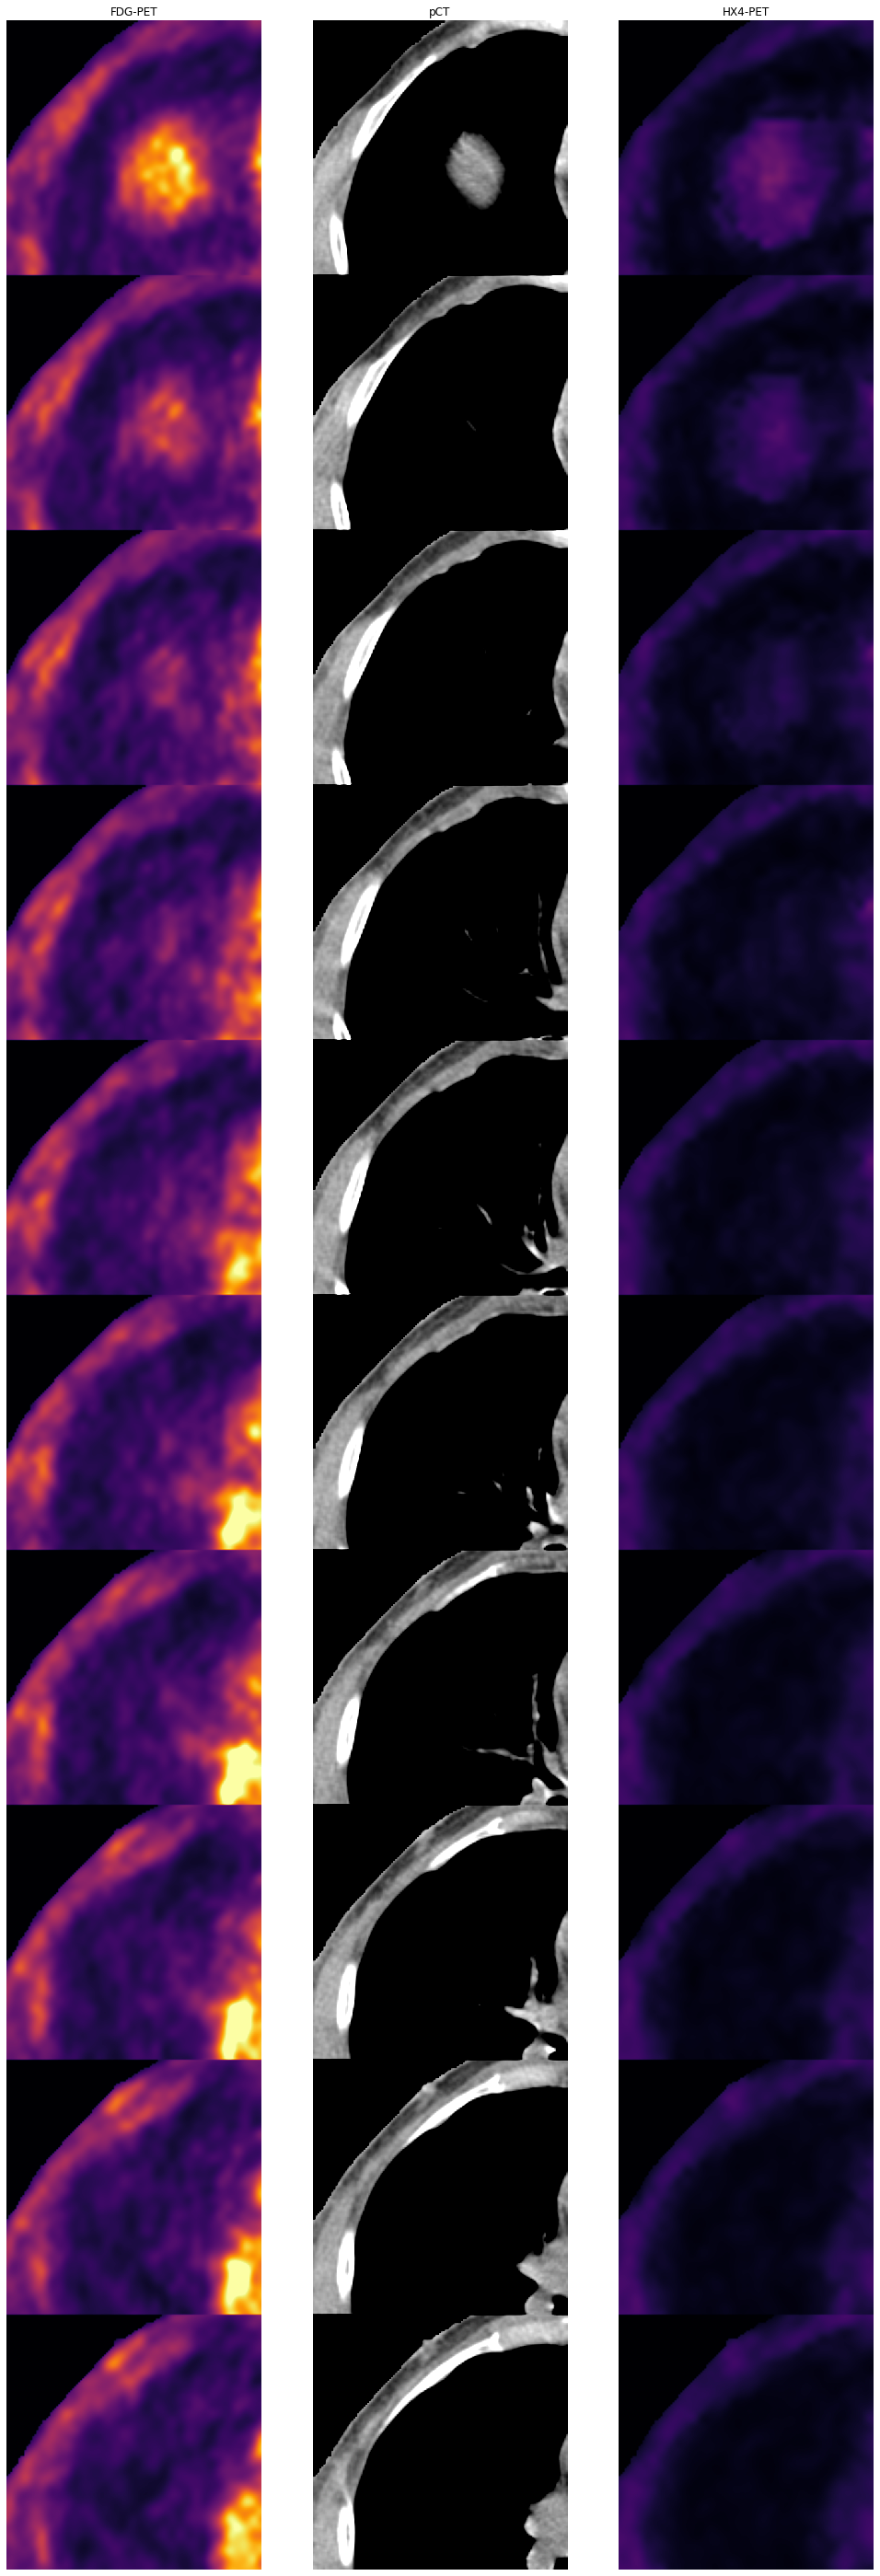

In [10]:
# Visualization
fdg_pet = sample['A'][0, :, :, :].numpy().transpose(2,1,0)
pct = sample['A'][1, :, :, :].numpy().transpose(2,1,0)
hx4_pet = sample['B'][0, :, :, :].numpy().transpose(2,1,0)

visualizer.set_spacing((1,1,3))
visualizer.multi_image_strips([fdg_pet, pct, hx4_pet], 
                              image_types=['PET', 'CT', 'PET'], 
                              idx_range=[0, 10], 
                              view='axial',
                              subtitles=['FDG-PET', 'pCT', 'HX4-PET'])

## Unpaired data

### Dataset config and init

In [14]:
root_path = "/home/chinmay/Datasets/HX4-PET-Translation/Processed/train"
paired = False    
require_ldct_for_training= True 
patch_size = (32, 128, 128)  # DHW
patch_sampling = 'uniform-random-within-body-sf'
focal_region_proportion = (0.6, 0.3, 0.3)
hu_range = (-1000, 2000)
fdg_suv_range = (0.0, 15.0)   
hx4_tbr_range = (0.0, 3.0)  

# Init
unpaired_train_dataset = HX4PETTranslationTrainDataset(root_path, paired, require_ldct_for_training, 
                                                       patch_size, patch_sampling,
                                                       hu_range, fdg_suv_range, hx4_tbr_range, 
                                                       focal_region_proportion)
print(len(unpaired_train_dataset))

15


### Fetch data sample and visualize

In [15]:
sample_idx = 0

sample = unpaired_train_dataset[sample_idx]

print(sample['A'].shape)
print(sample['B'].shape)

torch.Size([2, 32, 128, 128])
torch.Size([2, 32, 128, 128])


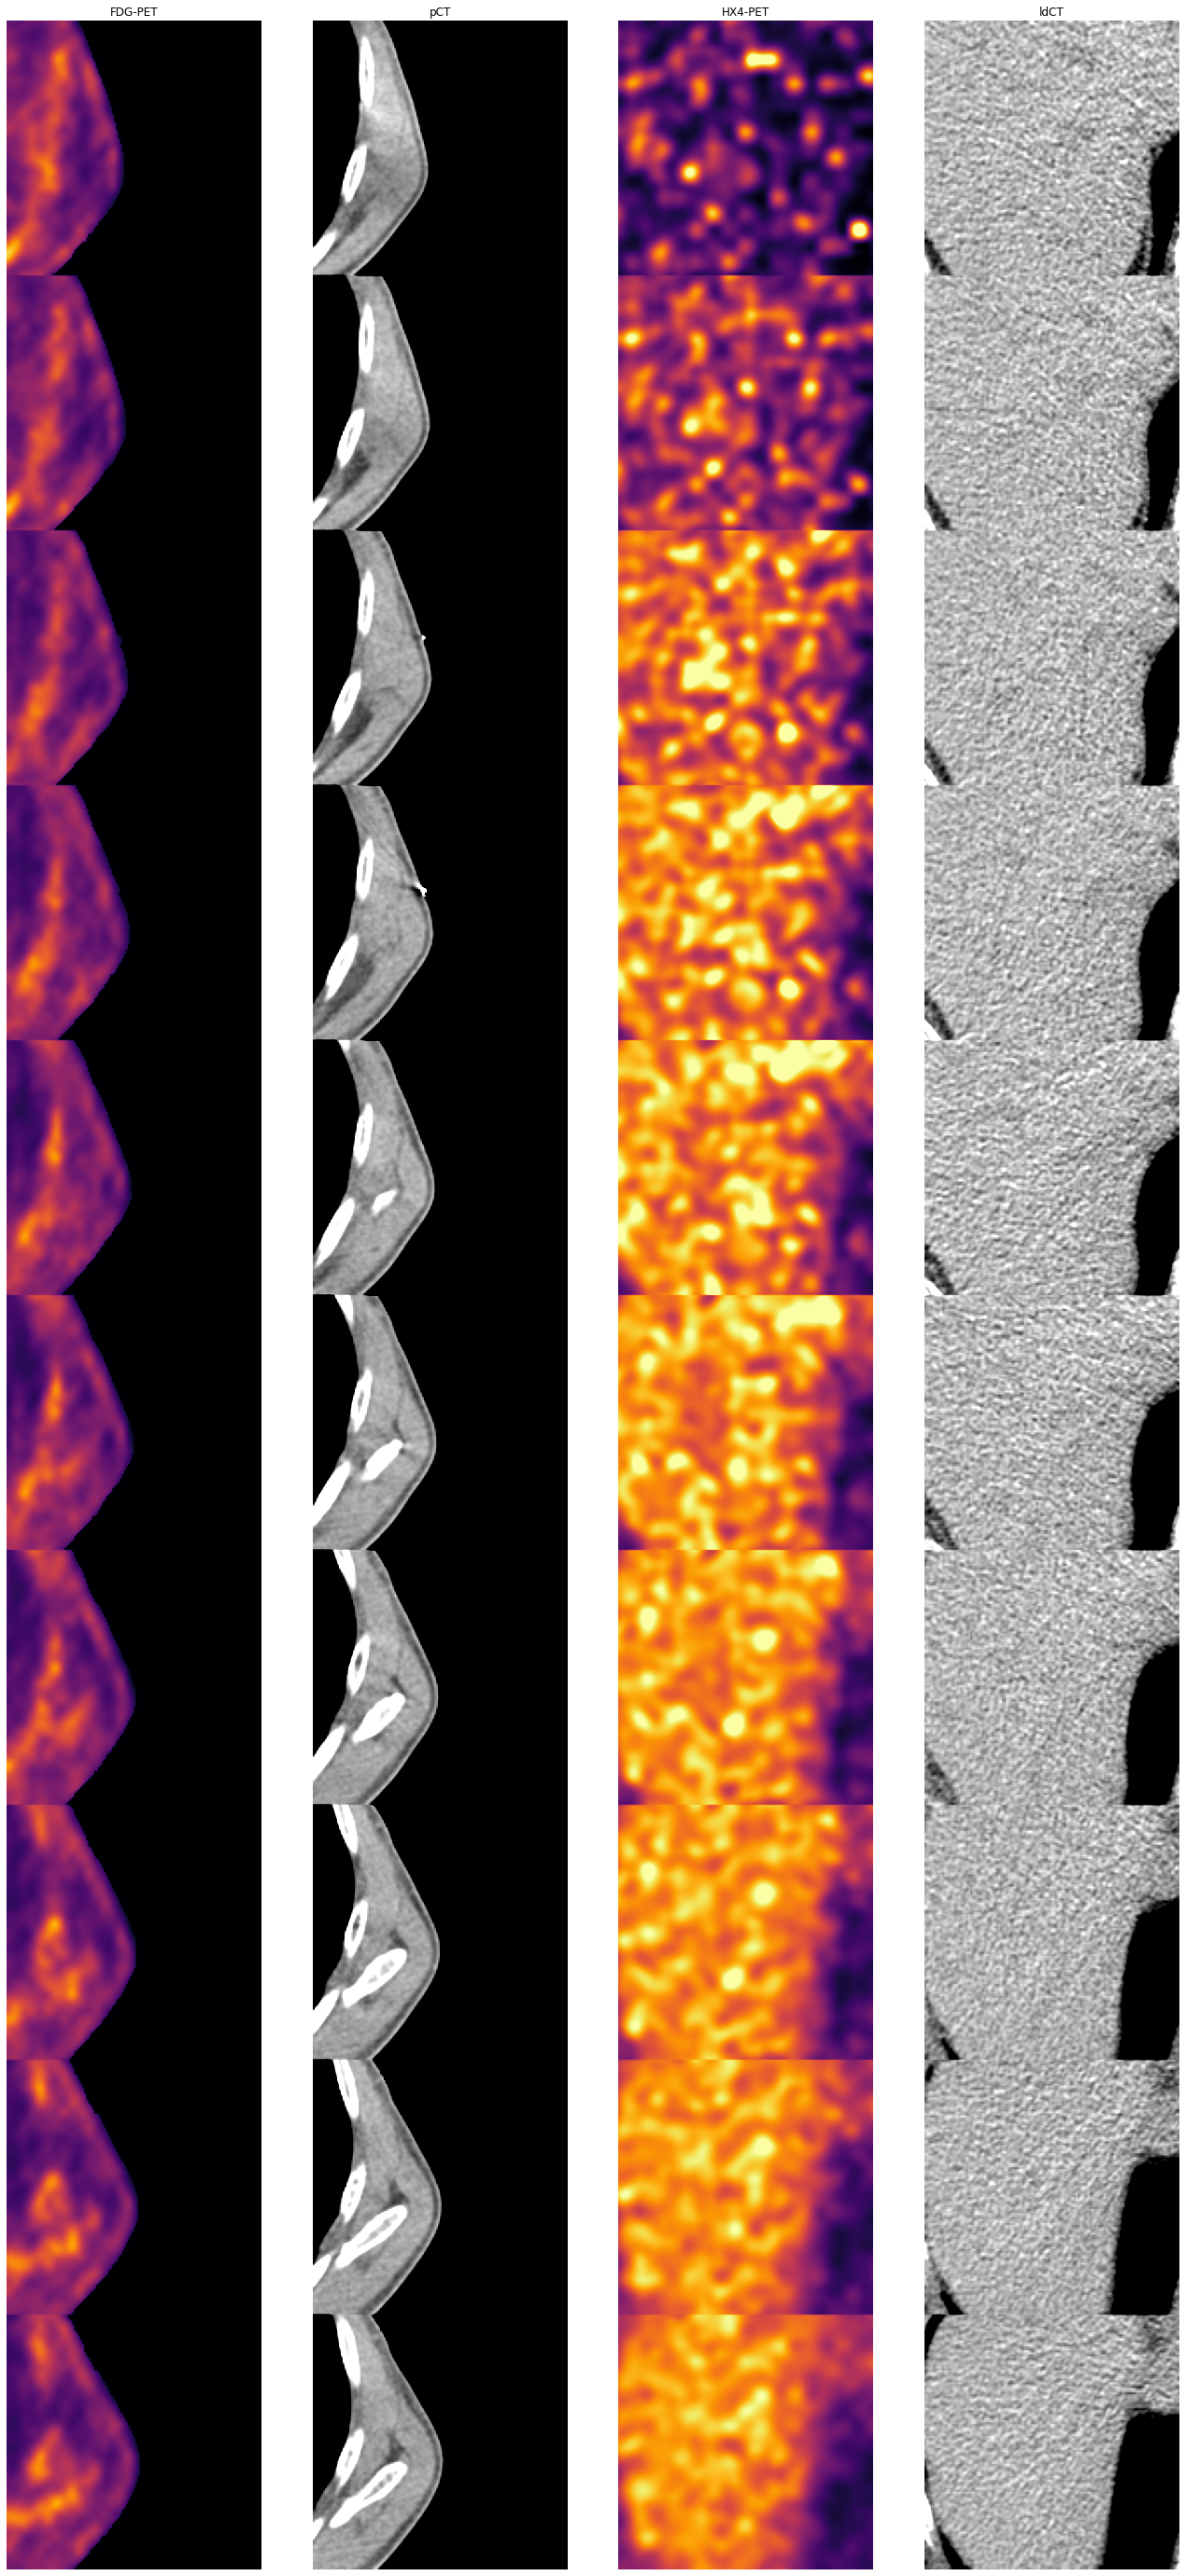

In [16]:
# Visualization
fdg_pet = sample['A'][0, :, :, :].numpy().transpose(2,1,0)
pct = sample['A'][1, :, :, :].numpy().transpose(2,1,0)
hx4_pet = sample['B'][0, :, :, :].numpy().transpose(2,1,0)
ldct = sample['B'][1, :, :, :].numpy().transpose(2,1,0)

visualizer.set_spacing((1,1,3))
visualizer.multi_image_strips([fdg_pet, pct, hx4_pet, ldct], 
                              image_types=['PET', 'CT', 'PET', 'CT'], 
                              idx_range=[0, 10], 
                              view='axial',
                              subtitles=['FDG-PET', 'pCT', 'HX4-PET', 'ldCT'])